## Introduction

Sentiment analysis offers music professionals valuable insights into fan reception that go beyond basic engagement metrics, helping artists and labels make data-informed decisions about marketing strategies, content adjustments, and future releases. In the digital age, where fan engagement largely occurs on platforms like YouTube, understanding the emotional tone of audience feedback provides a deeper layer of insight into how content resonates with listeners. Positive, negative, or neutral sentiments expressed in comments can reveal nuanced reactions that traditional metrics alone might overlook.

As digital engagement continues to shape the music industry's landscape, sentiment analysis emerges as a powerful tool for interpreting audience reactions, anticipating trends, and fostering stronger connections with fans. By analyzing sentiment data from YouTube comments, artists and industry professionals can better understand audience preferences, adapt to emerging trends, and refine their content strategies to build a more loyal fan base. This study explores the potential of sentiment analysis as a strategic asset in the music industry, enabling artists to understand and respond to the complex emotional landscape of their audience.

In [1]:
import pandas as pd
from googleapiclient.discovery import build 
import re 
import emoji
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import time
from datetime import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.linear_model import LinearRegression
import numpy as np
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

## Data Extraction - YouTube API

YouTube API was used to gather detailed information from Doechii's YouTube channel, including video metadata and audience engagement metrics. The code retrieves the channel’s unique ID, accesses the playlist of uploaded videos, and collects data for each video, such as title, views, likes, comment count, tags, category, duration, and engagement ratios (like-to-view and comment-to-view). Additionally, it extracts up to 200 comments per video, storing both the comment text and associated video details in a structured DataFrame. This organized dataset provides valuable insights into video performance and audience engagement.

In [2]:
# Load environment variables
load_dotenv("Data_api.env")
API_KEY = os.getenv("YOUTUBE_KEY")

CHANNEL_USERNAME = '@IamdoechiiTV'  # Doechii's YouTube channel name with @ symbol

# Initialize the YouTube API client
youtube = build('youtube', 'v3', developerKey=API_KEY)

In [3]:
# Step 1: Get the channel ID using the username
def get_channel_id(username):
    response = youtube.search().list(
        part='snippet',
        q=username,
        type='channel',
        maxResults=1
    ).execute()
    
    if 'items' in response and response['items']:
        channel_id = response['items'][0]['snippet']['channelId']
        return channel_id
    else:
        print("Could not find the channel.")
        return None

# Step 2: Get the channel's uploads playlist ID
def get_uploads_playlist_id(channel_id):
    response = youtube.channels().list(
        part='contentDetails',
        id=channel_id
    ).execute()
    
    if 'items' in response and response['items']:
        uploads_playlist_id = response['items'][0]['contentDetails']['relatedPlaylists']['uploads']
        return uploads_playlist_id
    else:
        print("Could not find the uploads playlist.")
        return None

# Step 3: Retrieve video IDs from the uploads playlist
def get_video_ids_from_playlist(playlist_id, max_videos=100):
    video_ids = []
    next_page_token = None
    while len(video_ids) < max_videos:
        response = youtube.playlistItems().list(
            part='contentDetails',
            playlistId=playlist_id,
            maxResults=50,
            pageToken=next_page_token
        ).execute()
        
        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])
        
        next_page_token = response.get('nextPageToken')
        if not next_page_token:
            break
            
    return video_ids[:max_videos]

# Step 4: Retrieve video details
def get_video_details(video_id):
    response = youtube.videos().list(
        part='snippet,statistics,contentDetails',
        id=video_id
    ).execute()
    
    if 'items' in response and response['items']:
        video_info = response['items'][0]
        
        # Snippet details
        title = video_info['snippet']['title']
        published_at = video_info['snippet']['publishedAt']
        tags = video_info['snippet'].get('tags', [])
        category_id = video_info['snippet'].get('categoryId', 'Unknown')

        # Statistics
        view_count = int(video_info['statistics'].get('viewCount', 0))
        like_count = int(video_info['statistics'].get('likeCount', 0))
        comment_count = int(video_info['statistics'].get('commentCount', 0))
        
        # Engagement ratios
        like_to_view_ratio = like_count / view_count if view_count else 0
        comment_to_view_ratio = comment_count / view_count if view_count else 0
        
        # Content details
        duration = video_info['contentDetails']['duration']
        
        return {
            'title': title,
            'published_at': published_at,
            'view_count': view_count,
            'like_count': like_count,
            'comment_count': comment_count,
            'like_to_view_ratio': like_to_view_ratio,
            'comment_to_view_ratio': comment_to_view_ratio,
            'duration': duration,
            'tags': tags,
            'category_id': category_id
        }
    else:
        print(f"Could not retrieve details for video ID: {video_id}")
        return None

# Step 5: Calculate time since posted
def calculate_time_since_posted(published_at):
    published_date = datetime.strptime(published_at, '%Y-%m-%dT%H:%M:%SZ')
    time_delta = datetime.now() - published_date
    return time_delta.days  # Return days since posted

# Step 6: Pull comments for each video
def get_comments(video_id, max_comments=200):
    comments = []
    next_page_token = None
    while len(comments) < max_comments:
        response = youtube.commentThreads().list(
            part="snippet",
            videoId=video_id,
            maxResults=100,
            pageToken=next_page_token
        ).execute()
        
        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            comments.append(comment)
        
        next_page_token = response.get('nextPageToken')
        if not next_page_token:
            break
            
    return comments[:max_comments]

# Fetch video comments and save to DataFrame with additional metadata
def fetch_comments_for_channel(username, max_videos=100, max_comments=200):
    # Get channel ID from username
    channel_id = get_channel_id(username)
    if not channel_id:
        return pd.DataFrame()  # Return an empty DataFrame if no channel ID found
    
    # Get uploads playlist ID
    playlist_id = get_uploads_playlist_id(channel_id)
    if not playlist_id:
        return pd.DataFrame()  # Return an empty DataFrame if no playlist ID found

    # Get video IDs from the uploads playlist
    video_ids = get_video_ids_from_playlist(playlist_id, max_videos)
    
    # Fetch comments and metadata for each video and store in a list
    all_comments = []
    print(f"Fetching details and comments of the videos....")
    for video_id in video_ids:
        
        
        # Get video details
        video_details = get_video_details(video_id)
        if not video_details:
            continue
        
        # Calculate days since posted
        days_since_posted = calculate_time_since_posted(video_details['published_at'])
        
        # Fetch comments for the video
        video_comments = get_comments(video_id, max_comments)
        
        # Append each comment along with video metadata
        for comment in video_comments:
            all_comments.append({
                'artist_name': 'Doechii',  # Static artist name as an example
                'video_id': video_id,
                'video_title': video_details['title'],
                'views': video_details['view_count'],
                'likes': video_details['like_count'],
                'comments_count': video_details['comment_count'],
                'like_to_view_ratio': video_details['like_to_view_ratio'],
                'comment_to_view_ratio': video_details['comment_to_view_ratio'],
                'duration': video_details['duration'],
                'tags': video_details['tags'],
                'category_id': video_details['category_id'],
                'days_since_posted': days_since_posted,
                'comment': comment
            })
        
        time.sleep(1)  # Add a small delay to avoid hitting rate limits

    # Convert list of comments to DataFrame
    df = pd.DataFrame(all_comments)
    return df

# Run the function to fetch comments
df = fetch_comments_for_channel(CHANNEL_USERNAME, max_videos=100, max_comments=200)


print("Comments and metadata have been stored")

Fetching details and comments of the videos....
Comments and metadata have been stored


In [4]:
# Drop rows with any missing values
df = df.replace("", pd.NA).dropna(how='any')
df.head()

,artist_name,video_id,video_title,views,likes,comments_count,like_to_view_ratio,comment_to_view_ratio,duration,tags,category_id,days_since_posted,comment
0,Doechii,c0mEgEMMvQ8,Doechii - WAIT (Live Park Performance),91523,9209,496,0.10062,0.005419,PT5M23S,[],10,39,human natureがくるとは予想外！<br>めちゃくちゃ良いなぁ！！
1,Doechii,c0mEgEMMvQ8,Doechii - WAIT (Live Park Performance),91523,9209,496,0.10062,0.005419,PT5M23S,[],10,39,this track is more than fire.. it gives soundt...
2,Doechii,c0mEgEMMvQ8,Doechii - WAIT (Live Park Performance),91523,9209,496,0.10062,0.005419,PT5M23S,[],10,39,Yebo Goddess!
3,Doechii,c0mEgEMMvQ8,Doechii - WAIT (Live Park Performance),91523,9209,496,0.10062,0.005419,PT5M23S,[],10,39,❤
4,Doechii,c0mEgEMMvQ8,Doechii - WAIT (Live Park Performance),91523,9209,496,0.10062,0.005419,PT5M23S,[],10,39,Tiny Desk Performance!!!!!!❤❤❤


## Data Cleaning 

The text data is preprocessed to remove noise that may interfere with sentiment analysis. The steps involved include:

   - **Lowercasing Text**: Convert all text to lowercase to ensure consistency.
   - **Replacing Emojis**: Remove any emojis from the text.
   - **Removing URLs, Mentions, Hashtags, and Numbers**: Eliminate URLs, mentions (`@username`), hashtags (`#topic`), and numbers as they do not contribute to sentiment.
   - **Removing Punctuation**: Strip out punctuation to keep the text clean and focused on the words.
   - **Bias Removal**: Remove instances of the artist’s name, "doechii," and similar variations to prevent biased results.
   - **Tokenization**: Split the text into individual words (tokens) for further processing.
   - **Removing Stop Words and Short Words**: Remove common stop words (e.g., "the", "is") and words shorter than three characters to reduce noise.
   - **Lemmatization**: Normalize words by converting them to their base form (e.g., "running" becomes "run") for consistency across similar words.

In [5]:
# Define a function to remove emojis from a string
def remove_emojis(text):
    # This regex pattern matches emojis and other non-standard characters
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002700-\U000027BF"  # other symbols
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Apply the remove_emojis function to each comment in the DataFrame
df['comment'] = df['comment'].apply(remove_emojis)
comments = df[["video_id", "comment"]].copy()

In [6]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize stop words, stemmer, and lemmatizer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def text_processing(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs, mentions, hashtags, numbers, and punctuation
    text = re.sub(r"http\S+|@\w+|#\w+|\d+", "", text)
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    
    # Remove the word "doechii" and similar variations to avoid bias
    text = re.sub(r'\bdoechii\b|\bdoechi\b|\bdoe\b', '', text)
    
    # Tokenize and remove stop words, short words
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    
    # Lemmatize tokens to normalize words
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    
    # Join tokens back into a single string
    return ' '.join(lemmatized_tokens)

comments['comment'] = comments['comment'].apply(text_processing)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/raghavirajumohan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/raghavirajumohan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/raghavirajumohan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/raghavirajumohan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Sentiment Scoring

Apply a sentiment scoring model to the text to determine the overall sentiment of each comment. This process includes:

   - **Calculate Sentiment Scores**: For each comment, calculate:
     - **Positive Score**: Proportion of positive sentiment in the comment.
     - **Negative Score**: Proportion of negative sentiment in the comment.
     - **Neutral Score**: Proportion of neutral sentiment in the comment.
     - **Compound Score**: A normalized score summarizing overall sentiment on a scale from -1 (most negative) to +1 (most positive).

   - **Label Sentiment**: Based on the compound score, assign each comment a label:
       - **Positive** if the compound score $ > 0.05 $
       - **Negative** if the compound score $ < -0.05 $
       - **Neutral** if $ -0.05 \leq \text{compound score} \leq 0.05 $

This sentiment scoring approach allows us to systematically evaluate and label the sentiment of each comment.

In [7]:
# Initialize the VADER sentiment analyzer
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# Updating VADER's lexicon based on manual analysis of comments 
custom_words = {
    'fire': 2.0,
    'hard': 2.0,
    'obsessed': 2.0,
    'lit': 1,   
    'hard': 1,
    'damn': 1,
    'dope': 1,
    'sick': 1.5, 
    'crazy': 1.5,
    'fine': 0.5,
    'dope': 1.5,        
    'trash': -2.5,   
    'hate': -2.5, 
    'shit': -2.5,
    'bomb': 2.0, 
    'stupid': -2.5, 
    'hate': -2.5, 
    
}

sid.lexicon.update(custom_words)

# Run VADER sentiment analysis on the preprocessed text
comments['Positive'] = [sid.polarity_scores(comment)["pos"] for comment in comments['comment']]
comments['Negative'] = [sid.polarity_scores(comment)["neg"] for comment in comments['comment']]
comments['Neutral'] = [sid.polarity_scores(comment)["neu"] for comment in comments['comment']]
comments['Compound'] = [sid.polarity_scores(comment)["compound"] for comment in comments['comment']]

# Determine sentiment label based on compound score
sentiment = []
for score in comments['Compound']:
    if score >= 0.05:
        sentiment.append('Positive')
    elif score <= -0.05:
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')

# Add sentiment labels to the DataFrame
comments['Sentiment'] = sentiment

# Display the first few rows to check the results
comments.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/raghavirajumohan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,video_id,comment,Positive,Negative,Neutral,Compound,Sentiment
0,c0mEgEMMvQ8,human naturebr,0.000,0.0,1.000,0.0000,Neutral
1,c0mEgEMMvQ8,track fire give soundtrack movie vibe putting ...,0.268,0.0,0.732,0.9854,Positive
2,c0mEgEMMvQ8,yebo goddess,0.000,0.0,1.000,0.0000,Neutral
3,c0mEgEMMvQ8,,0.000,0.0,0.000,0.0000,Neutral
4,c0mEgEMMvQ8,tiny desk performance,0.000,0.0,1.000,0.0000,Neutral


## Sentiment Analysis Visuals

### Distribution of Comment Sentiments

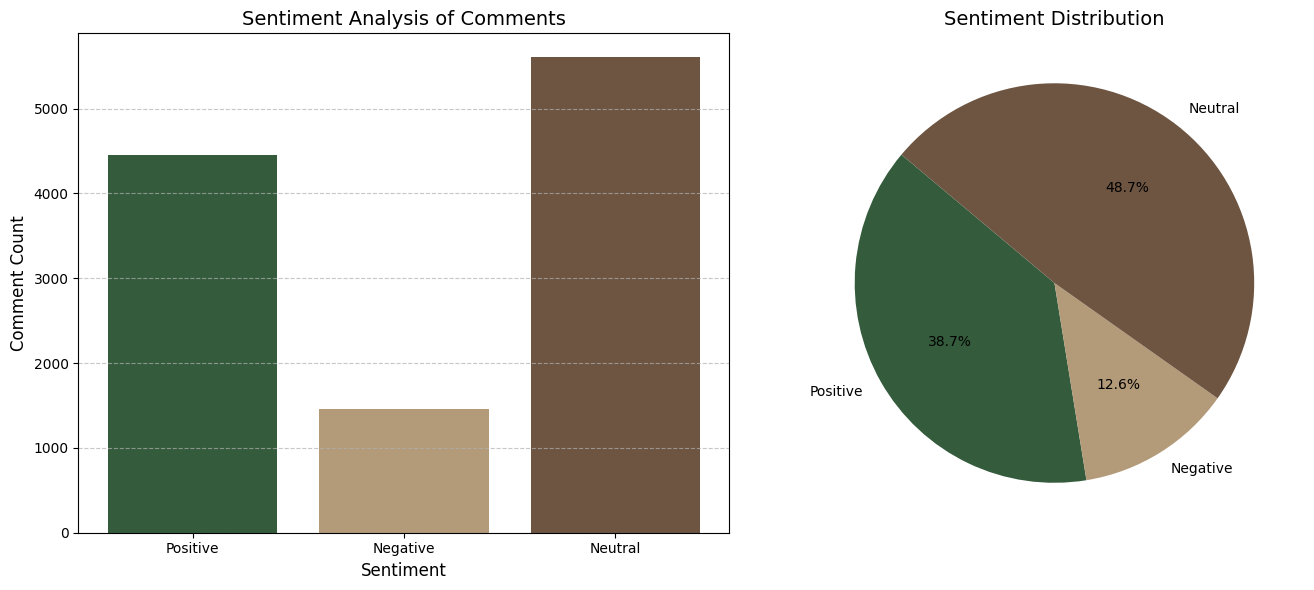

In [8]:
# Count the number of comments in each sentiment category
positive_count = len(comments[comments['Sentiment'] == 'Positive'])
negative_count = len(comments[comments['Sentiment'] == 'Negative'])
neutral_count = len(comments[comments['Sentiment'] == 'Neutral'])

# Labels and data for visualizations
labels = ['Positive', 'Negative', 'Neutral']
comment_counts = [positive_count, negative_count, neutral_count]

# Updated color scheme based on the provided aesthetic (dark green, beige, brown shades)
colors = ['#345C3C', '#B39A79', '#6D5542']

# Create a 1x2 grid for the bar and pie charts
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Create a bar chart for sentiment distribution
axes[0].bar(labels, comment_counts, color=colors)
axes[0].set_xlabel('Sentiment', fontsize=12)
axes[0].set_ylabel('Comment Count', fontsize=12)
axes[0].set_title('Sentiment Analysis of Comments', fontsize=14)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Create a pie chart for sentiment distribution
axes[1].pie(comment_counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
axes[1].set_title('Sentiment Distribution', fontsize=14)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## Sentiment-Specific Word Clouds

To further explore the prominent words associated with each sentiment category, we generate word clouds for **Positive** and **Negative** sentiments. These word clouds visually represent the frequency of words within each sentiment, with larger words indicating higher frequency.

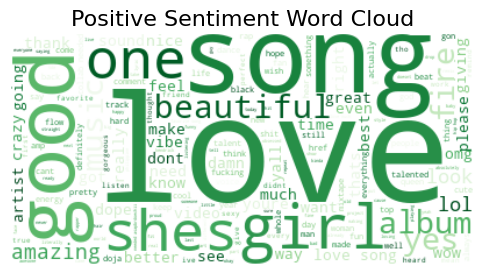

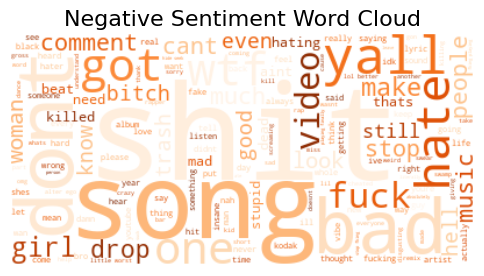

In [9]:
# Function to plot word clouds with specified colors
def plot_word_cloud(text, title, color):
    wordcloud = WordCloud(width=400, height=200, background_color='white', colormap=color).generate(text)
    plt.figure(figsize=(6, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Colors for positive and negative word clouds
colors = {
    'Positive': 'Greens',  # Shades of green for positive
    'Negative': 'Oranges'  # Shades of orange/brown for negative
}

# Generate word clouds for positive and negative sentiments only
for sentiment, color in colors.items():
    # Concatenate all comments for the current sentiment into one string
    text = ' '.join(comments[comments['Sentiment'] == sentiment]['comment'])
    
    # Plot the word cloud
    plot_word_cloud(text, f'{sentiment} Sentiment Word Cloud', color)


## Model Building

In [10]:
# Drop the polarity score columns and keep only necessary columns
comments = comments.drop(['Positive', 'Negative', 'Neutral', 'Compound'], axis=1)

# Encoding Sentiment Labels
data_copy = comments.copy()
le = LabelEncoder()
data_copy['Sentiment'] = le.fit_transform(data_copy['Sentiment'])

### i. Balancing Sentiment Classes with Upsampling

In [11]:
# Separate classes
df_positive = data_copy[data_copy['Sentiment'] == 2]  # Assuming 2 is 'Positive'
df_neutral = data_copy[data_copy['Sentiment'] == 1]   # Assuming 1 is 'Neutral'
df_negative = data_copy[data_copy['Sentiment'] == 0]  # Assuming 0 is 'Negative'

# Upsample minority classes to match the majority class size
n_samples = max(len(df_positive), len(df_neutral), len(df_negative))
df_negative_upsampled = resample(df_negative, replace=True, n_samples=n_samples, random_state=42)
df_neutral_upsampled = resample(df_neutral, replace=True, n_samples=n_samples, random_state=42)
df_positive_upsampled = resample(df_positive, replace=True, n_samples=n_samples, random_state=42)

# Concatenate balanced classes
final_data = pd.concat([df_negative_upsampled, df_neutral_upsampled, df_positive_upsampled])

# Check class distribution
print(final_data['Sentiment'].value_counts())

Sentiment
0    5608
1    5608
2    5608
Name: count, dtype: int64


### ii. Text Vectorization Using CountVectorizer

To convert the cleaned text data into a numerical format suitable for machine learning, we use **CountVectorizer**, which transforms text into a matrix of word counts.

In [12]:
# Initialize CountVectorizer and fit-transform the cleaned comments
cv = CountVectorizer(max_features=1500)
X = cv.fit_transform(final_data['comment']).toarray()
y = final_data['Sentiment'].values

### iii. Model Training

In [13]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Initialize and train the model
classifier = GaussianNB()
classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = classifier.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7060221870047544
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.43      0.58      1628
           1       0.74      0.95      0.83      1722
           2       0.61      0.72      0.66      1698

    accuracy                           0.71      5048
   macro avg       0.74      0.70      0.69      5048
weighted avg       0.73      0.71      0.69      5048



### iv. Model Evaluation

Accuracy: 0.7060221870047544


<Figure size 1000x800 with 0 Axes>

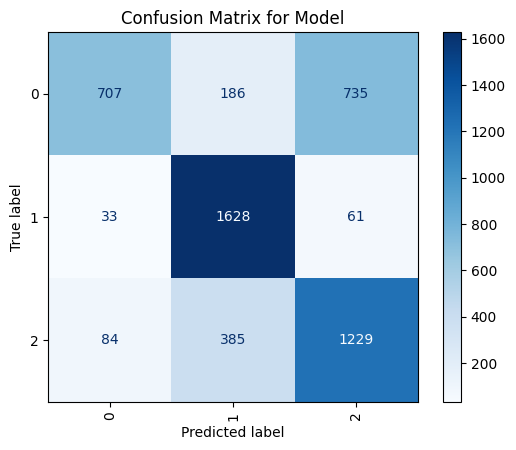

In [14]:
# Generate predictions on the test set
y_pred = classifier.predict(X_test)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('\033[1;34mAccuracy:\033[0m', accuracy)  # Bold and blue title

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot(cmap='Blues', xticks_rotation=90)
plt.title("Confusion Matrix for Model")
plt.show()

## Sentiment-Based Regression Analysis

In this step, I prepare data for a regression analysis that examines the relationship between video engagement metrics and average sentiment scores.

In [15]:
# Data Preparatin of Regression Model
df = df.drop(columns=['comment'], errors='ignore')  

# Merge the datasets on the 'video_id' column
merged_df = pd.merge(df, comments[['video_id', 'comment', 'Sentiment']], on='video_id', how='left')

# Display the first few rows of the merged DataFrame
merged_df.head()

,artist_name,video_id,video_title,views,likes,comments_count,like_to_view_ratio,comment_to_view_ratio,duration,tags,category_id,days_since_posted,comment,Sentiment
0,Doechii,c0mEgEMMvQ8,Doechii - WAIT (Live Park Performance),91523,9209,496,0.10062,0.005419,PT5M23S,[],10,39,human naturebr,Neutral
1,Doechii,c0mEgEMMvQ8,Doechii - WAIT (Live Park Performance),91523,9209,496,0.10062,0.005419,PT5M23S,[],10,39,track fire give soundtrack movie vibe putting ...,Positive
2,Doechii,c0mEgEMMvQ8,Doechii - WAIT (Live Park Performance),91523,9209,496,0.10062,0.005419,PT5M23S,[],10,39,yebo goddess,Neutral
3,Doechii,c0mEgEMMvQ8,Doechii - WAIT (Live Park Performance),91523,9209,496,0.10062,0.005419,PT5M23S,[],10,39,,Neutral
4,Doechii,c0mEgEMMvQ8,Doechii - WAIT (Live Park Performance),91523,9209,496,0.10062,0.005419,PT5M23S,[],10,39,tiny desk performance,Neutral


In [16]:
# Sentiment column converted to numerical values
sentiment_mapping = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
merged_df['Sentiment'] = merged_df['Sentiment'].map(sentiment_mapping)

# Group by 'video_id' and calculate aggregate metrics
grouped_df = merged_df.groupby('video_id').agg({
    'Sentiment': 'mean',             # Average sentiment score for each video
    'views': 'mean',                 # Average view count for each video
    'likes': 'mean',                 # Average likes count
    'like_to_view_ratio': 'mean',    # Average like-to-view ratio
    'comments_count': 'mean'  ,
    'comment_to_view_ratio': 'mean'# Average comment count
}).reset_index()

# Display the grouped DataFrame
grouped_df.head()

,video_id,Sentiment,views,likes,like_to_view_ratio,comments_count,comment_to_view_ratio
0,-JRqB5pKro4,1.280000,165938.0,18844.0,0.113560,585.0,0.003525
1,-MtLqyXoW1Y,1.247619,63320.0,2866.0,0.045262,134.0,0.002116
2,0xEWutSR7iE,1.363636,59544.0,3851.0,0.064675,64.0,0.001075
3,15BJ32cohbE,1.183544,115940.0,4009.0,0.034578,204.0,0.001760
4,1MOYuZ32rbQ,1.375000,195966.0,6502.0,0.033179,77.0,0.000393


In [19]:
# Log-transform the 'views' column to reduce skewness
grouped_df['log_views'] = np.log(grouped_df['views'])
grouped_df['log_likes'] = np.log(grouped_df['likes'])

# Run a regression using the formula method in statsmodels
# Here, we include 'Sentiment', 'comments_count', 'like_to_view_ratio', and their interaction term
model = smf.ols(formula='log_views ~ Sentiment  + log_likes ', data=grouped_df)
results = model.fit()

# Display the summary of the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              log_views   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     956.8
Date:                Tue, 12 Nov 2024   Prob (F-statistic):           1.40e-64
Time:                        00:28:48   Log-Likelihood:                -47.392
No. Observations:                 100   AIC:                             100.8
Df Residuals:                      97   BIC:                             108.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.9152      0.495      7.903      0.0

This OLS regression analysis explores how average sentiment (`Sentiment`) and the log-transformed like count (`log_likes`) relate to the log-transformed view count (`log_views`) of videos. With an R-squared value of 0.952, the model explains 95.2% of the variance in `log_views`, indicating a very strong fit. The `log_likes` variable has a significant positive effect on views, suggesting that videos with higher likes generally attract more views.

Interestingly, `Sentiment` has a negative coefficient (-0.7390) and is statistically significant, indicating that videos with more neutral or negative sentiments may attract slightly higher view counts. This could imply that content with neutral or slightly negative sentiment drives higher engagement, possibly due to controversy or curiosity.

## Conclusion

This analysis highlights the critical role that sentiment analysis of YouTube comments can play in understanding audience engagement within the music industry. By examining viewer sentiments alongside traditional engagement metrics like views, likes, and comments, we gain a more nuanced perspective on how content resonates with audiences. Our findings suggest that sentiment polarity—whether positive, negative, or neutral—may influence video view counts, potentially driving curiosity and engagement even for content that generates mixed or critical responses.